# Install libraries

In [1]:
# Library required for displaying static images with plotly

# !pip install -U kaleido

# Import Libraries

In [2]:
#Load the required libraries

import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima.utils import ndiffs
import pmdarima as pm

import warnings

warnings.filterwarnings("ignore")

In [3]:
# # comment this cell if you don't mind to displaying static plotly charts on github

# import plotly.io as pio
# pio.renderers.default = "png"

# Import Data

In [4]:
df = pd.read_csv("../data/BTCUSDT_final.csv")

In [5]:
df.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,2020-01-01 00:59:59.999,3.675857e+06,7640,226.153126,1.624289e+06
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,2020-01-01 01:59:59.999,6.365953e+06,9033,570.721419,4.114804e+06
2,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,2020-01-01 02:59:59.999,4.736719e+06,7466,357.180263,2.582514e+06
3,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,2020-01-01 03:59:59.999,5.667367e+06,8337,394.810811,2.854987e+06
4,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,2020-01-01 04:59:59.999,3.379094e+06,5896,243.514706,1.759053e+06


Here's a breakdown of each feature:

- **date**: This represents the opening time of a specific period

- **open**: This refers to the opening price of the trading instrument at the given period.

- **high**: This represents the highest price reached by the trading instrument during the specified period.

- **low**: This denotes the lowest price reached by the trading instrument during the specified period.

- **close**: This indicates the closing price of the trading instrument at the given period.

- **volume**: This refers to the total volume, typically the quantity of the trading instrument, traded during the specified period.

- **close_time**: This represents the closing time of the specific period in Unix time format.

- **quote_volume**: This refers to the total volume in terms of the quote asset. The quote asset is the asset used to determine the value of the trading instrument.

- **count**: This represents the number of trades that occurred during the specified period.

- **taker_buy_volume**: This denotes the volume of the quote asset bought by takers (market takers) during the specified period.

- **taker_buy_quote_volume**: This represents the volume of the base asset bought by takers (market takers) during the specified period.

In [6]:
# Renaming the open_time column to date

df.rename(columns = {'open_time':'date'}, inplace = True)

In [7]:
df.head(2)

,date,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,2020-01-01 00:59:59.999,3.675857e+06,7640,226.153126,1.624289e+06
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,2020-01-01 01:59:59.999,6.365953e+06,9033,570.721419,4.114804e+06


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29897 entries, 0 to 29896
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    29897 non-null  object 
 1   open                    29897 non-null  float64
 2   high                    29897 non-null  float64
 3   low                     29897 non-null  float64
 4   close                   29897 non-null  float64
 5   volume                  29897 non-null  float64
 6   close_time              29897 non-null  object 
 7   quote_volume            29897 non-null  float64
 8   count                   29897 non-null  int64  
 9   taker_buy_volume        29897 non-null  float64
 10  taker_buy_quote_volume  29897 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.5+ MB


In [9]:
# Removing close time column

df = df.drop(columns=['close_time'])

In [10]:
df.head(2)

,date,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,3.675857e+06,7640,226.153126,1.624289e+06
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,6.365953e+06,9033,570.721419,4.114804e+06


# Exploratory Data Analysis

## Datetime Conversion

In [11]:
# Converting the Date column from object to datetime
df[["date"]] = df[["date"]].apply(pd.to_datetime)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29897 entries, 0 to 29896
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    29897 non-null  datetime64[ns]
 1   open                    29897 non-null  float64       
 2   high                    29897 non-null  float64       
 3   low                     29897 non-null  float64       
 4   close                   29897 non-null  float64       
 5   volume                  29897 non-null  float64       
 6   quote_volume            29897 non-null  float64       
 7   count                   29897 non-null  int64         
 8   taker_buy_volume        29897 non-null  float64       
 9   taker_buy_quote_volume  29897 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.3 MB


## Missing Hours

In [13]:
df = df.set_index('date')

In [14]:
# Check Missing hours in the dataframe

start_date = df.index.min()
end_date = df.index.max()
full_range = pd.date_range(start=start_date, end=end_date, freq='1H')

# Calculate the missing hours by finding the set difference between the full range and the existing dates
missing_hours = set(full_range) - set(df.index)

# Initialize a list to store the missing hours and their corresponding indices
missing_info = []

# Iterate through the missing hours and find the index before and after each missing hour
for missing_hour in missing_hours:

    index_before = df[df.index < missing_hour].index.max()
    index_after = df[df.index > missing_hour].index.min()
    missing_info.append((missing_hour, index_before, index_after))


# Get the number of missing hours
num_missing_hours = len(missing_info)

# Convert the missing_info list to a DataFrame for better visualization
missing_info_df = pd.DataFrame(missing_info, columns=['Missing Hour', 'Index Before', 'Index After'])

print(f"Number of missing hours: {num_missing_hours}")
print("--- Missing Hours ---")

missing_info_df

Number of missing hours: 31
--- Missing Hours ---


,Missing Hour,Index Before,Index After
0,2020-02-19 14:00:00,2020-02-19 11:00:00,2020-02-19 17:00:00
1,2020-04-25 02:00:00,2020-04-25 01:00:00,2020-04-25 04:00:00
2,2020-02-19 16:00:00,2020-02-19 11:00:00,2020-02-19 17:00:00
3,2021-04-25 07:00:00,2021-04-25 04:00:00,2021-04-25 08:00:00
4,2020-06-28 04:00:00,2020-06-28 01:00:00,2020-06-28 05:00:00
5,2021-09-29 07:00:00,2021-09-29 06:00:00,2021-09-29 09:00:00
6,2020-12-25 02:00:00,2020-12-25 01:00:00,2020-12-25 03:00:00
7,2023-03-24 13:00:00,2023-03-24 12:00:00,2023-03-24 14:00:00
8,2021-04-25 06:00:00,2021-04-25 04:00:00,2021-04-25 08:00:00
9,2021-08-13 05:00:00,2021-08-13 01:00:00,2021-08-13 06:00:00


In [15]:
# Interpolate to fill in the missing hours with the mean

# Create a new DataFrame with the complete range of hours
new_df = pd.DataFrame(index=full_range)

# Merge the original DataFrame with the new DataFrame to fill in the missing hours
bitcoin_df = new_df.merge(df, how='left', left_index=True, right_index=True)

# Interpolate the missing values in each column
columns_to_interpolate = list(df.columns)
bitcoin_df[columns_to_interpolate] = bitcoin_df[columns_to_interpolate].interpolate()

# Reset Index
bitcoin_df.reset_index(inplace = True)

# Rename the index back to date
bitcoin_df = bitcoin_df.rename(columns={bitcoin_df.columns[0]: 'date'})

bitcoin_df

,date,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,3.675857e+06,7640.0,226.153126,1.624289e+06
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,6.365953e+06,9033.0,570.721419,4.114804e+06
2,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,4.736719e+06,7466.0,357.180263,2.582514e+06
3,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,5.667367e+06,8337.0,394.810811,2.854987e+06
4,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,3.379094e+06,5896.0,243.514706,1.759053e+06
...,...,...,...,...,...,...,...,...,...,...
29923,2023-05-31 19:00:00,27037.06,27123.43,27000.20,27010.57,1064.241890,2.879819e+07,28990.0,482.385940,1.305342e+07
29924,2023-05-31 20:00:00,27010.57,27116.13,27005.16,27114.20,835.439160,2.262138e+07,22409.0,440.842910,1.193703e+07
29925,2023-05-31 21:00:00,27114.19,27119.77,27045.61,27090.79,644.019020,1.744376e+07,19452.0,254.039400,6.879695e+06
29926,2023-05-31 22:00:00,27090.78,27193.24,27084.92,27183.98,999.118680,2.711602e+07,26045.0,517.765690,1.405207e+07


In [16]:
len(df), len(bitcoin_df)

(29897, 29928)

In [17]:
# Check the index 1191 which was missing to see the interpolation

bitcoin_df.iloc[1189:1195]

,date,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
1189,2020-02-19 13:00:00,10133.330,10183.333333,10122.806667,10152.266667,1611.018115,1.639698e+07,14348.0,783.708038,7.977562e+06
1190,2020-02-19 14:00:00,10137.495,10200.000000,10125.380000,10153.935000,2213.542417,2.253890e+07,19182.0,1071.050008,1.090734e+07
1191,2020-02-19 15:00:00,10141.660,10216.666667,10127.953333,10155.603333,2816.066719,2.868082e+07,24016.0,1358.391979,1.383713e+07
1192,2020-02-19 16:00:00,10145.825,10233.333333,10130.526667,10157.271667,3418.591021,3.482274e+07,28850.0,1645.733950,1.676691e+07
1193,2020-02-19 17:00:00,10149.990,10250.000000,10133.100000,10158.940000,4021.115323,4.096466e+07,33684.0,1933.075921,1.969669e+07
1194,2020-02-19 18:00:00,10157.570,10200.000000,10131.250000,10194.770000,2036.271681,2.069327e+07,26362.0,997.160921,1.013549e+07


## Missing Count

In [18]:
def missing_values_summary(df):
    missing_counts = df.isnull().sum()
    total_count = df.shape[0]  # Total number of rows in the DataFrame

    missing_df = pd.DataFrame({'Column': missing_counts.index, 'Missing Count': missing_counts.values})
    missing_df['Missing Percentage'] = (missing_df['Missing Count'] / total_count) * 100

    return missing_df

In [19]:
missing_values_summary(bitcoin_df)

,Column,Missing Count,Missing Percentage
0,date,0,0.0
1,open,0,0.0
2,high,0,0.0
3,low,0,0.0
4,close,0,0.0
5,volume,0,0.0
6,quote_volume,0,0.0
7,count,0,0.0
8,taker_buy_volume,0,0.0
9,taker_buy_quote_volume,0,0.0


## Plot and Analysis of Columns

### OHCL Columns

In [20]:
# Extracting the index of the Bitcoin Crash in March 2020

bitcoin_df[bitcoin_df["date"] == "2020-03-12"].index

Index([1704], dtype='int64')

In [21]:
# Extracting the index of the Bitcoin Crash in March 2020

bitcoin_df[bitcoin_df["date"] == "2022-11-08"].index

Index([25008], dtype='int64')

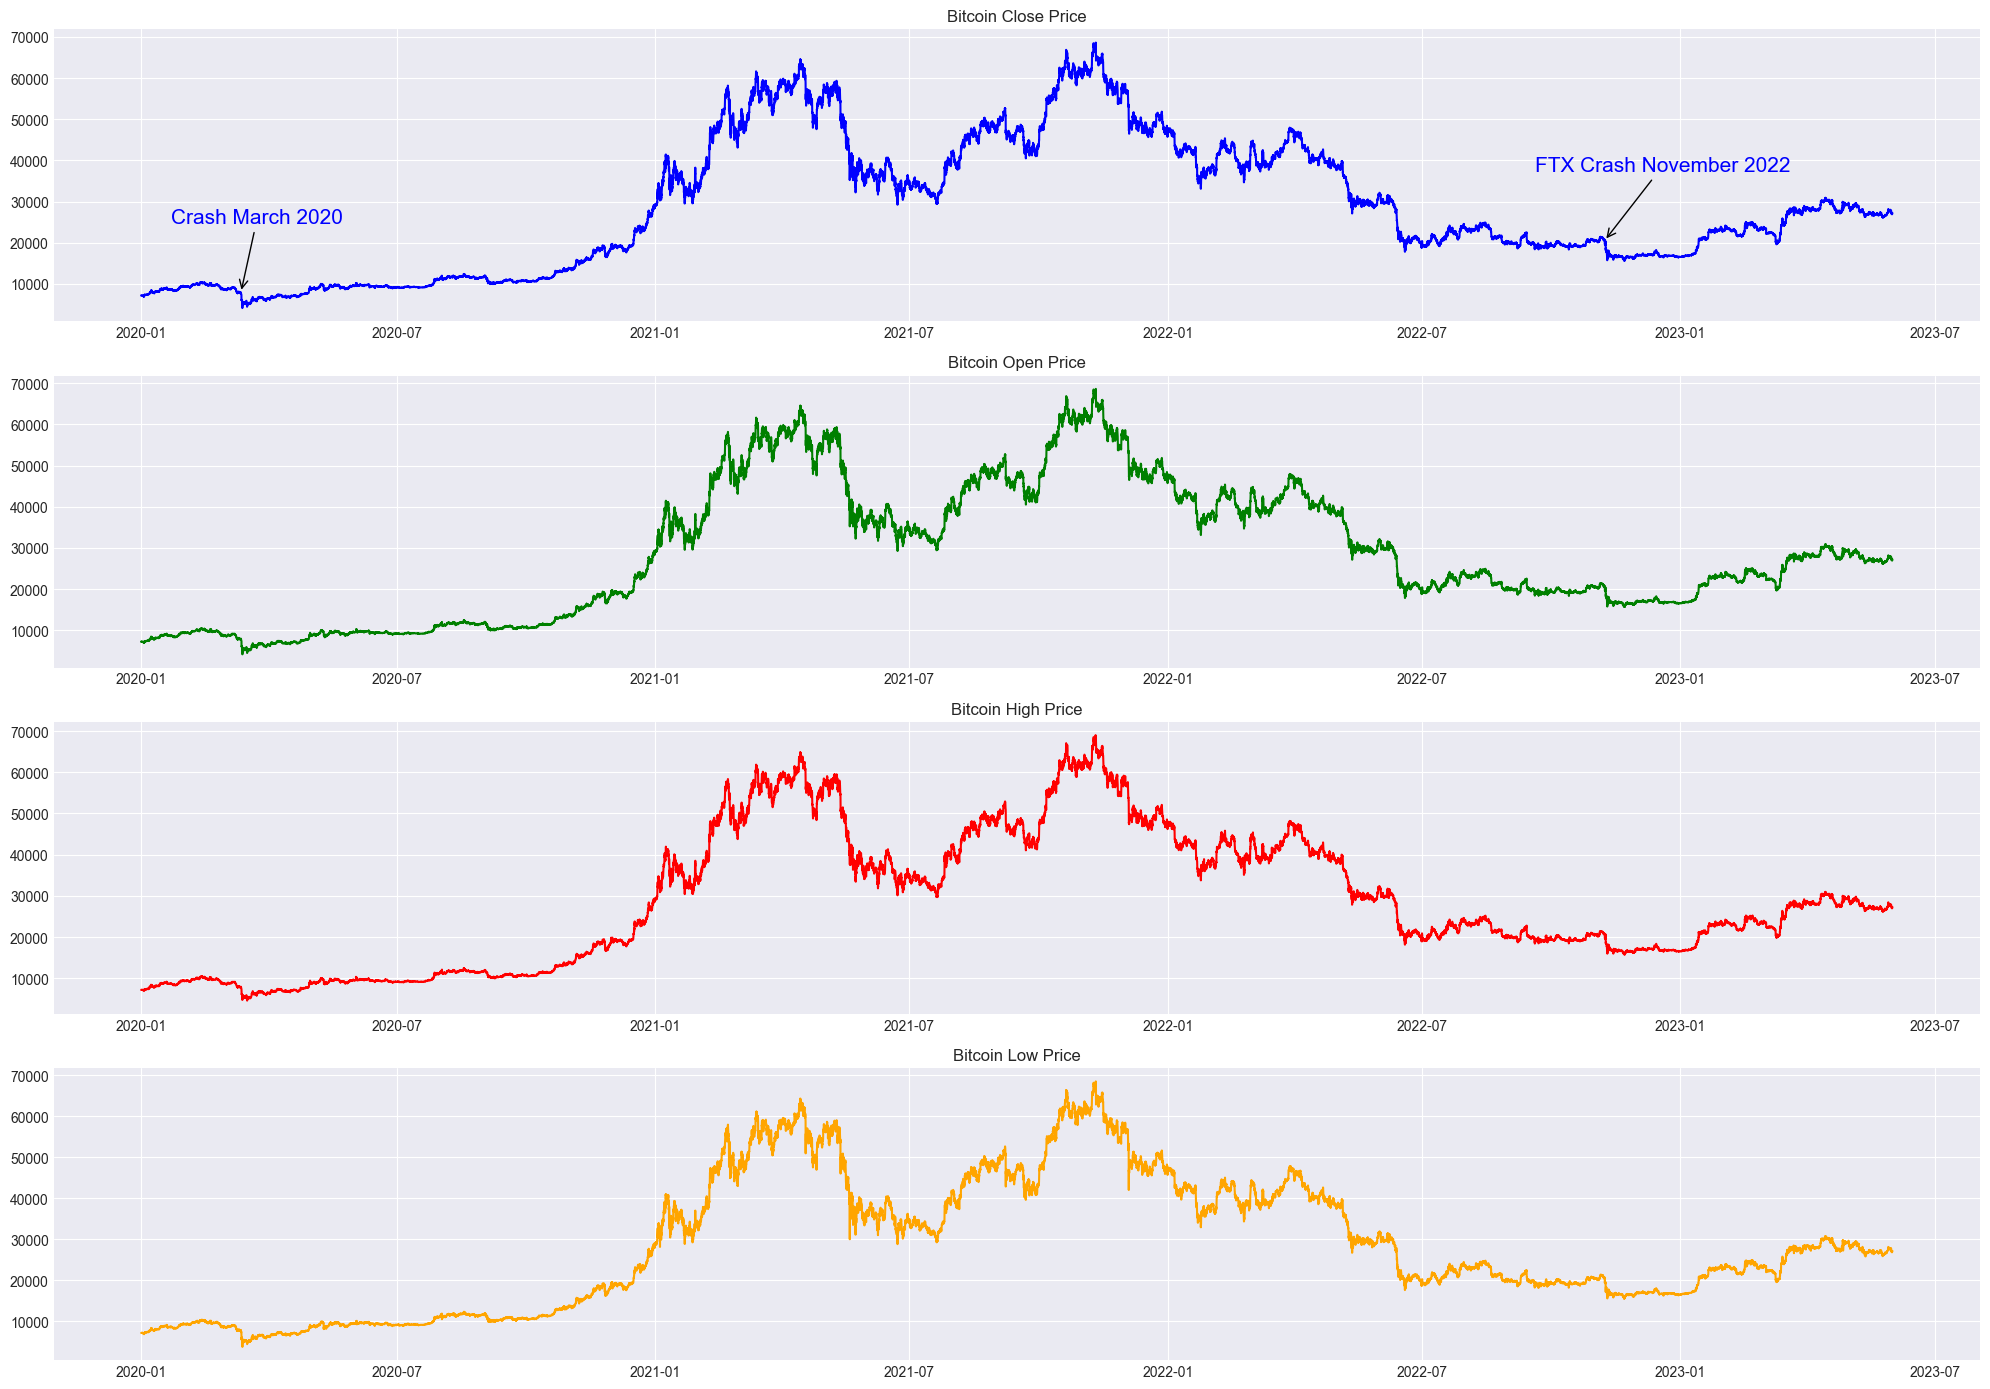

In [22]:
# Plotting OHCL

# Set the figure size
plt.figure(figsize=(20, 14))

# Plotting Close price
plt.subplot(4, 1, 1)
plt.plot(bitcoin_df["date"], bitcoin_df["close"], color='blue')
plt.title("Bitcoin Close Price")

# Plotting Open price
plt.subplot(4, 1, 2)
plt.plot(bitcoin_df["date"], bitcoin_df["open"], color='green')
plt.title("Bitcoin Open Price")

# Plotting High price
plt.subplot(4, 1, 3)
plt.plot(bitcoin_df["date"], bitcoin_df["high"], color='red')
plt.title("Bitcoin High Price")

# Plotting Low price
plt.subplot(4, 1, 4)
plt.plot(bitcoin_df["date"], bitcoin_df["low"], color='orange')
plt.title("Bitcoin Low Price")

# Add annotation for Crash 2020 in first plot
plt.subplot(4, 1, 1)  # Select the Close price subplot for annotation
plt.annotate('Crash March 2020',
             xy=(bitcoin_df["date"][1704], bitcoin_df["close"][1704]),
             xytext=(-50, 50), textcoords='offset points', fontsize=15, color='blue',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.annotate('FTX Crash November 2022',
             xy=(bitcoin_df["date"][25008], bitcoin_df["close"][25008]),
             xytext=(-50, 50), textcoords='offset points', fontsize=15, color='blue',
             arrowprops=dict(arrowstyle='->', color='black'))


# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()




In [ ]:
# Plotting Detail of the Bitcoin crash of March 2020

plot_ = bitcoin_df.set_index("date").loc["2020-03"]

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['open'],
                    high=plot_['high'],
                    low=plot_['low'],
                    close=plot_['close'],
                    increasing_line_color='green',
                    decreasing_line_color='red'))

fig.update_layout(title="Bitcoin March 2020",
                  width=1400,  # Adjust the width of the figure
                  height=500,  # Adjust the height of the figure
                  margin=dict(l=50, r=50, t=50, b=50))  # Adjust the margin around the plot

fig.show()



In [ ]:
# Plottin Detail of the Bitcoin crash of Nov 2022

plot_ = bitcoin_df.set_index("date").loc["2022-11"]

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['open'],
                    high=plot_['high'],
                    low=plot_['low'],
                    close=plot_['close'],
                    increasing_line_color='blue',
                    decreasing_line_color='red'))

fig.update_layout(title="Bitcoin November 2022",
                  width=1400,  # Adjust the width of the figure
                  height=500,  # Adjust the height of the figure
                  margin=dict(l=50, r=50, t=50, b=50))  # Adjust the margin around the plot

fig.show()



### Volume and Count Columns

In [ ]:
## Plot Volumes and Count


# Create subplots with shared x-axis
fig = make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Plotting Volume
fig.add_trace(go.Scatter(x=bitcoin_df["date"], y=bitcoin_df["volume"], name="Volume"), row=1, col=1)
fig.update_yaxes(title_text="Volume", row=1, col=1)

# Plotting Taker Buy Volume
fig.add_trace(go.Scatter(x=bitcoin_df["date"], y=bitcoin_df["taker_buy_volume"], name="Taker Buy Volume"), row=2, col=1)
fig.update_yaxes(title_text="Taker Buy Volume", row=2, col=1)

# Plotting Quote Volume
fig.add_trace(go.Scatter(x=bitcoin_df["date"], y=bitcoin_df["quote_volume"], name="Quote Volume"), row=3, col=1)
fig.update_yaxes(title_text="Quote Volume", row=3, col=1)

# Plotting Taker Buy Quote Volume
fig.add_trace(go.Scatter(x=bitcoin_df["date"], y=bitcoin_df["taker_buy_quote_volume"], name="Taker Buy Quote Volume"), row=4, col=1)
fig.update_yaxes(title_text="Taker Buy Quote Volume", row=4, col=1)

# Plotting Count
fig.add_trace(go.Scatter(x=bitcoin_df["date"], y=bitcoin_df["count"], name="Count"), row=5, col=1)
fig.update_yaxes(title_text="Count", row=5, col=1)

# Update layout
fig.update_layout(height=1000, width=800, showlegend=False)

# Set x-axis title
fig.update_xaxes(title_text="Date", row=5, col=1)


# Show the plot
fig.show()


In [ ]:
# Plotting together Quote Volume and Taker Buy Quote Volume as they have similar axis

plt.figure(figsize=(12, 6))

# Plotting Quote Volume and Taker Buy Quote Volume
plt.plot(bitcoin_df["date"], bitcoin_df["quote_volume"], label="Quote Volume")
plt.plot(bitcoin_df["date"], bitcoin_df["taker_buy_quote_volume"], label="Taker Buy Quote Volume")



plt.title("Bitcoin Quote Volume and Taker Buy Quote Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Plotting together Volume and Taker Buy Volume as they have similar axis

plt.figure(figsize=(12, 6))

# Plotting Quote Volume and Taker Buy Quote Volume
plt.plot(bitcoin_df["date"], bitcoin_df["volume"], label="Volume")
plt.plot(bitcoin_df["date"], bitcoin_df["taker_buy_volume"], label="Taker Buy Volume")


plt.title("Bitcoin Volume and Taker Buy Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()

plt.tight_layout()
plt.show()

## Heatmap Correlation

In [ ]:
# Plot Bitcoin correlations

plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap')

# Create a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(bitcoin_df.corr(numeric_only=True), annot=True, cmap=cmap, fmt=".2f", linewidths=0.5, square=True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()


We can see that all OHCL are highly correlated with each other and all volumes and count as well with each other

## Plot Lag Correlation

Lag plots are most commonly used to look for patterns in time series data. We will try to find hourly, daily, weekly and monthly correlations, but will focus from now on, on the **Close Price**

In [ ]:
## Bitcoin Lag Plot

import matplotlib.pyplot as plt
import pandas as pd

# Define the lag values and corresponding labels
lags = [1, 24, 48, 168, 720]
labels = ['1-hour Lag', '1-Day Lag', '2-Day Lag', '1-Week Lag', '1-Month Lag']

# Create a color palette with different colors for each plot
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Create a figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Bitcoin Lag Plots', fontsize=22)

# Flatten the axs array to iterate over subplots
axs = axs.flatten()

# Plot the lag plots with different colors and labels
for i, lag in enumerate(lags):
    pd.plotting.lag_plot(bitcoin_df["close"], lag=lag, ax=axs[i], c=colors[i])
    axs[i].set_title(labels[i])

# Remove empty subplots if the number of lags is less than 9
if len(lags) < 9:
    for j in range(len(lags), 9):
        fig.delaxes(axs[j])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


We see that the hourly and daily lag is correlated but the weekly get some noise for both currencies. Therefore we can keep working with the daily lag

## Daily Resampling

Here we will resample based on the correlation using the resample method from pandas

In [ ]:
# Bitcoin Daily resampling taking the mean value

bitcoin_df.set_index('date', inplace=True)  # Set 'date' column as the index

bitcoin_daily = bitcoin_df.resample('24H').mean()
bitcoin_daily = bitcoin_daily.reset_index()

bitcoin_daily.head()

In [ ]:
missing_values_summary(bitcoin_daily)

### Daily Time Series Analysis

In [ ]:
# Bitcoin Daily Time Series

fig = px.line(bitcoin_daily, x='date', y='close', title='Bitcoin Close Price with Range Slider and Selectors')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")

        ])
    )
)

fig.show()

In [ ]:
# Plotting Detail of the Bitcoin crash of March 2020

plot_ = bitcoin_daily.set_index("date").loc["2020-03"]

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['open'],
                    high=plot_['high'],
                    low=plot_['low'],
                    close=plot_['close'],
                    increasing_line_color='green',
                    decreasing_line_color='red'))

fig.update_layout(title="Bitcoin March 2020",
                  width=1400,  # Adjust the width of the figure
                  height=500,  # Adjust the height of the figure
                  margin=dict(l=50, r=50, t=50, b=50))  # Adjust the margin around the plot

fig.show()



In [ ]:
# Plottin Detail of the Bitcoin crash of Nov 2022

plot_ = bitcoin_daily.set_index("date").loc["2022-11"]

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['open'],
                    high=plot_['high'],
                    low=plot_['low'],
                    close=plot_['close'],
                    increasing_line_color='blue',
                    decreasing_line_color='red'))

fig.update_layout(title="Bitcoin November 2022",
                  width=1400,  # Adjust the width of the figure
                  height=500,  # Adjust the height of the figure
                  margin=dict(l=50, r=50, t=50, b=50))  # Adjust the margin around the plot

fig.show()

## Time Series Decomposition and Statistical Test

### Decomposition

In [ ]:
# Additive Decomposition

series = bitcoin_daily.close
result = seasonal_decompose(series, model='additive', period=1)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

axes[0].set_title('Close Series')
axes[0].plot(series, color='blue')

axes[1].set_title('Trend Component')
axes[1].plot(result.trend, color='green')

axes[2].set_title('Seasonal Component')
axes[2].plot(result.seasonal, color='red')

axes[3].set_title('Residual Component')
axes[3].plot(result.resid, color='orange')

plt.show()


In [ ]:
# Multiplicative Decomposition

series = bitcoin_daily.close
result_mul = seasonal_decompose(series, model='multiplicative', period=1)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

axes[0].set_title('Close Series')
axes[0].plot(series, color='blue')

axes[1].set_title('Trend Component')
axes[1].plot(result_mul.trend, color='green')

axes[2].set_title('Seasonal Component')
axes[2].plot(result_mul.seasonal, color='red')

axes[3].set_title('Residual Component')
axes[3].plot(result_mul.resid, color='orange')

plt.show()


The plots show no seasonality and no variance over time (see plot seasonal).

Residuals values are a around a mean with similar/no variance, so we need further to explore

### Autocorrelation: ACF and PACF

In [ ]:
# Plot each correlation in an autocorrelation graph (ACF) below. Correlation coefficients vs. Nr. lags

def plot_autocorrelation(series, lags=50, alpha=0.05):
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_acf(series, lags=lags, alpha=alpha, ax=ax)
    ax.set_title("Autocorrelation Function (ACF) for Close Price", size=16)
    ax.set_xlabel("Lag", size=12)
    ax.set_ylabel("Autocorrelation", size=12)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()

plot_autocorrelation(series, lags=50, alpha=0.05)

# All values outside the blue area are significant. It represents like in linear regression, the significance of the beta values
# Meaning the smaller the blue cone the better as we have more values outside and our confidence interval is higher

# Peak inside of cone ➔ not statistically significant. Not applicable in our case

# But we can add more lags as the more we have, the better our model will predict, as past values predict future values linearly in the ACF


Analysing the ACF for a specific time lag could be a good predictor for the current value...


...but only at face value!


ACF measures direct & indirect effects

This is why we must analyse each lag by isolation as well!
Using our linear modelling, we can isolate each lag term
This is known as Auto Regression (AR) and the analysis of lag terms is known as a **Partial Autocorrelation Function (PACF)**

In [ ]:
# Plot each partial autocorrelation in an autocorrelation graph (PACF) below. Correlation coefficients vs. Nr. lags

def plot_partial_autocorrelation(series, lags=50, alpha=0.05, method='ols'):
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_pacf(series, lags=lags, alpha=alpha, method=method, ax=ax)
    ax.set_title("Partial Autocorrelation Function (PACF) for Close Price", size=16)
    ax.set_xlabel("Lag", size=12)
    ax.set_ylabel("Partial Autocorrelation", size=12)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()

plot_partial_autocorrelation(series, lags=50, alpha=0.05, method='ols')

# Count the number of lags before the values drop below the confidence levels (blue)
#  Note that the first lag is ignored, as it represents / between and itself
# We see the number of lags is 2, as more than that is not statistically significant


### Stationarity

#### Kwiatkowski-Phillips-Schmidt-Shin: KPSS

In [ ]:
def test_stationarity(series):
    print('Results of KPPS Test:')
    result = kpss(series, 'ct')
    stats = result[0]
    p = result[1]
    lags = result[2]
    critical_values = result[3]

    data = {
        'Test Statistics': [stats],
        'p-value': [p],
        'Lags Used': [lags],
        'Critical Value (10%)': [critical_values['10%']],
        'Critical Value (5%)': [critical_values['5%']],
        'Critical Value (2.5%)': [critical_values['2.5%']],
        'Critical Value (1%)': [critical_values['1%']]
    }

    df = pd.DataFrame(data)
    df['Series Stationarity'] = 'Stationary' if p >= 0.05 else 'Not Stationary'

    return df


In [ ]:
results_kpps = test_stationarity(series)
results_kpps

#### Augmented Dickey Fuller - ADF
ADF tests the following null hypothesis:

H0: The series is not-stationary

A p-value close to 0 (e.g. p < 0.05) indicates stationarity

In [ ]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    p_value_adf = dftest[1]

    data = {
        'Test Statistic': [dftest[0]],
        'p-value': [p_value_adf],
        '#Lags Used': [dftest[2]]
    }

    for key, value in dftest[4].items():
        data[f'Critical Value ({key})'] = [value]

    data['Series Stationarity'] = ['Not Stationary' if p_value_adf > 0.05 else 'Stationary']

    df = pd.DataFrame(data)
    return df


In [ ]:
results_adf = adf_test(series)
results_adf

The final result is that the series are **"Not Stationary"**

#### Differencing

Here we get non-stationary. So we need to do [differencing](https://https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) to make the series stationary

Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis cannot be rejected. Hence, the series is non stationary.

Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test.

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- Case 1: Both tests conclude that the series is not stationary - The series is
not stationary

- Case 2: Both tests conclude that the series is stationary - The series is stationary

- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

**Here is an example of the procedure to follow when we need to do differencing**

In [ ]:
# Adding 1 level of differencing

def plot_series_and_difference(series):
    series_diff = series.diff(1)

    plt.figure(figsize=(10, 4))
    plt.subplot(2, 1, 1)
    series.plot(color='blue')
    plt.title('Original Series')

    plt.subplot(2, 1, 2)
    series_diff.dropna().plot(color='orange')
    plt.title('Differenced Series')

    plt.tight_layout()
    plt.show()


plot_series_and_difference(series)


In [ ]:
adf_test(series.diff(1).dropna())

In [ ]:
test_stationarity(series.diff(1).dropna())

**ADF and KPPS are now stationary with one level of differencing (d = 1)**

In [ ]:
# ACF for d = 1

def plot_acf_diff(series, lags):
    series_diff = series.diff(1).dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(series_diff, lags=lags, alpha=0.05, ax=ax)
    ax.set_title("ACF for Differenced Series (d=1)", size=20)
    plt.show()


plot_acf_diff(series, lags=50)


In [ ]:
# PACF for d = 1

def plot_pacf_diff(series, lags):
    series_diff = series.diff(1).dropna()
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_pacf(series_diff, lags=lags, alpha=0.05, method='ols', ax=ax)
    ax.set_title("PACF for Differenced Series (d=1)", size=20)
    plt.show()

plot_pacf_diff(series, lags=50)


We use the PACF plot to calculate the value for **p = 1** (nr of lags, excluding the first, till it drops into the blue area)
We use the ACF plot to calculate the value for **q = 1** (nr of lags, excluding the first, till it drops into the blue area)

This means we can use an ARIMA model (1,1,1), but we can also calculate p,q and d using `ndiffs` or `pm.auto_arima` automatically

In [ ]:
# Automatically estimate differencing term

ndiffs(series)

In [ ]:
# Automatically estimate p,d,q terms

arima_model = pm.auto_arima(series,
                            start_p=0, max_p=3,
                            start_q=0, max_q=3,
                            trend='t',
                            seasonal=False,
                            trace=True)

Here ARIMA has calculated (1,1,0).

Several models have similar AIC values around 20746 and our previous estimation is also good

Any of them might be the "true" underlying process

👉 When in doubt, pick the simplest model. In this case (1,1,0) is simpler

## Trends: Moving Average

Rolling or moving average is a method to average out noise, which are random short-term fluctuations in price, from data and make easier to detect trends. Splits and aggregating the data into windows accorging to functions like mean, median...

For example, a 7-day moving average reflects short-term trends in the stock market, whereas a 100-day rolling average indicates major trends in the stock market.

Here we calculate the **arithmetic mean** of a given set of prices over a specified period.

In [ ]:
bitcoin_daily = bitcoin_daily.set_index('date')

# compute a short-term 20-day moving average
MA20 = bitcoin_daily.close.rolling(20).mean()

# compute a Long-term 50-day moving average
MA50 = bitcoin_daily.close.rolling(50).mean()

# compute a Long-term 100-day moving average
MA100 = bitcoin_daily.close.rolling(100).mean()

In [ ]:
# Create a trace for the closing price
trace_close = go.Scatter(x=bitcoin_daily.index, y=bitcoin_daily.close, mode='lines', name='Closing')

# Create traces for the moving averages
trace_ma100 = go.Scatter(x=bitcoin_daily.index, y=MA100, mode='lines', name='MA100', line=dict(color='red'))
trace_ma50 = go.Scatter(x=bitcoin_daily.index, y=MA50, mode='lines', name='MA50', line=dict(color='green'))
trace_ma20 = go.Scatter(x=bitcoin_daily.index, y=MA20, mode='lines', name='MA20', line=dict(color='orange'))


layout = go.Layout(
    title='Bitcoin Moving Averages',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    showlegend=True,
    height = 800,
    width=1800  # Adjust the width as per your preference
)

# Create a figure and add the traces and layout
fig = go.Figure(data=[trace_close, trace_ma100, trace_ma50, trace_ma20], layout=layout)

# Show the plot
fig.show()


We can observe from the chart that in March and November of 2021, the price crosses below the 50-day MA, which indicates a **downward trend**, and in October 2020, the price crosses above the MA, which shows an **upward trend**.

From the charts that around March and December of 2021, the 20-day MA crosses below the 100-day MA. It indicates that the trend is shifting downwards, and **it’s a sell signal**. Towards January 2023, the 20-day MA crosses above the 100-day MA. It shows that the trend is shifting upwards, and it’s a **buy signal**.

Further investigating the charts in detail during 2021 or 2022 separately, which are the years with more fluctuations, can bring interesting insights

## Daily Return Series

A return, also known as a financial return, in its simplest terms, is the money made or lost on an investment over some period of time.

A return is a change in the price of an asset over time.

Returns can be positive, representing a profit, or negative, indicating a loss. Return series of an asset are easier to handle than price series and give a complete summary of the investment opportunity.

We will use the pandas **`pct_change()`** function to compute the returns.

These are relative price changes of the cryptocurrencies

In [ ]:
close_bitcoin = bitcoin_daily[["close"]]
close_bitcoin.head()

In [ ]:
# Returns i.e. percentage change in the adjusted close price and drop the first row with NA's

returns_bitcoin = close_bitcoin.pct_change().dropna(axis=0)
returns_bitcoin.reset_index(inplace = True)

In [ ]:
returns_bitcoin.head(2)

In [ ]:
returns_bitcoin[returns_bitcoin.date == "2020-03-12"].index

In [ ]:
returns_bitcoin[returns_bitcoin.date == "2022-11-08"].index

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(returns_bitcoin.date, returns_bitcoin['close'])
plt.title('Bitcoin Adjusted Closing Price')

plt.xlabel('Date')
plt.ylabel('Price')

plt.annotate('Crash March 2020',
             xy=(returns_bitcoin.date[70], returns_bitcoin["close"][70]),
             xytext=(50, -20), textcoords='offset points', fontsize=15, color='orange',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.annotate('FTX Crash November 2022',
             xy=(returns_bitcoin.date[1041], returns_bitcoin["close"][1041]),
             xytext=(-50, -100), textcoords='offset points', fontsize=15, color='orange',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()


For both cryptocurrencies, we can see a huge crash around March of 2020

### Volatilty

Volatility is a measure of change in the price of an asset over time. The higher the standard deviation, the more volatile an asset is.

In [ ]:
# Volatility, standard deviation of the returns

returns_bitcoin.close.std()

### Cumulative Returns

Cumulative return express the total change in the price of an asset over time.

We use the pandas **`cumprod()`** function to calculate the daily cumulative simple returns.

In [ ]:
# Cumulative return series
returns_bitcoin.set_index("date", inplace = True)

cum_returns_bitcoin = ((1 + returns_bitcoin).cumprod() - 1)*100
cum_returns_bitcoin.head()

In [ ]:
# Plotting the cumulative returns for Bitcoin
fig = px.line(title='Cumulative Returns - Bitcoin')
fig.add_scatter(x=cum_returns_bitcoin.index, y=cum_returns_bitcoin['close'], name='Bitcoin Close')

fig.update_xaxes(title='Date')
fig.update_yaxes(title='Cumulative Returns')

# Display the plot
fig.show()
